In [1]:
import torch

In [2]:
# !pip install -U timm

In [3]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from models.ch_mdl_dolg_efficientnet import ArcFaceLoss
from models.eff import get_model

In [4]:
# !unzip dont-stop-until-you-drop.zip

In [5]:
# !ls images/t_images

In [6]:
train = pd.read_csv('../whale/train.csv')
test = pd.read_csv('../whale/sample_submission.csv')
classes = list(set(train.individual_id))
classes_species = list(set(train.species))
sorted(classes)
sorted(classes_species)
display(train.head())
display(test.head())
print(len(classes))
print(len(classes_species))

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


15587
30


In [7]:
train['classes'] = train.groupby('individual_id').ngroup()
train['classes_species'] = train.groupby('species').ngroup()
train.head()

,image,species,individual_id,classes,classes_species
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,12348,18
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,1636,14
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,5842,9
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,4551,2
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,8721,14


In [8]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../whale/crop/train_images'
TEST_PATH = '../whale/crop/test_images'

In [9]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=8
    model_name='tf_efficientnet_b5_ns'
    size=448
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=15
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=12
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=6
    target_col='classes'
    target_col2 = 'classes_species'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
model_name = CFG.model_name
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [10]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD,AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(log_file=OUTPUT_DIR+f'{model_name}.log')


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [12]:
import sys
import importlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
import seaborn as sns
import scipy as sp
def cos_similarity_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds
def get_topk_cossim_sub(test_emb, tr_emb, vals_x=None, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    #vals_x = torch.tensor(vals_x, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        # sim_mat = torch.clamp(sim_mat,0,1) #- vals_x.repeat(sim_mat.shape[0], 1)
        
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds
def map_per_image(label, predictions):
    indexes = np.unique(predictions, return_index=True)[1]
    predictions = [predictions[index] for index in sorted(indexes)]
    t = np.where(predictions[:5]==label)[0]
    if len(t)>0:
        return 1 / (t[0] + 1)
    else:
        return 0.0

In [13]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  classes
0     4          1
      10         2
      13         1
      18         1
      19         1
                ..
4     15575      1
      15577      1
      15578      6
      15583      1
      15584      1
Length: 29343, dtype: int64


In [14]:
# from collections import Counter
# Counter((list(folds.classes)))

In [15]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image'].values
        self.labels = df['classes'].values
        self.labels_s = df['classes_species'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        label_species = torch.tensor(self.labels_s[idx]).long()
        return image, label,label_species
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

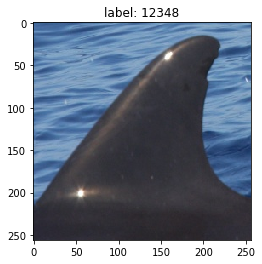

In [16]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label,label2 = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [17]:
import albumentations
class CutoutV2(albumentations.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return albumentations.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [18]:
# transforms_train = albumentations.Compose([
#     albumentations.Resize(CFG.size, CFG.size),
#     albumentations.HorizontalFlip(p=0.5),
#     albumentations.RandomBrightness(limit=0.2, p=0.75),
#     albumentations.RandomContrast(limit=0.2, p=0.75),

#     albumentations.OneOf([
#         albumentations.OpticalDistortion(distort_limit=1.),
#         albumentations.GridDistortion(num_steps=5, distort_limit=1.),
#     ], p=0.75),

#     albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
#     albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=5, border_mode=0, p=0.75),
#     CutoutV2(max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=1, p=0.75),
# ])
# transforms_val = albumentations.Compose([
#     albumentations.Resize(image_size, image_size),
# ])

In [19]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.RandomBrightness(limit=0.2, p=0.25),
            albumentations.RandomContrast(limit=0.2, p=0.25),
            albumentations.ImageCompression(quality_lower=99, quality_upper=100),
            albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.25),
            albumentations.ShiftScaleRotate(shift_limit=0.065, scale_limit=0.1, rotate_limit=360, border_mode=0, p=0.25),
            Cutout(max_h_size=int(CFG.size * 0.25), max_w_size=int(CFG.size * 0.25), num_holes=1, p=0.5),
#             ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

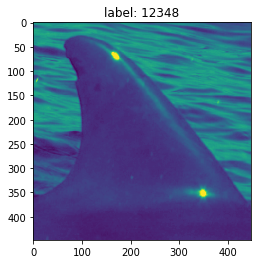

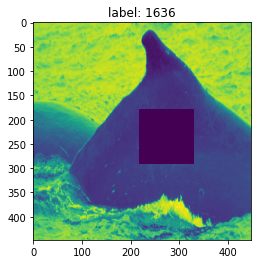

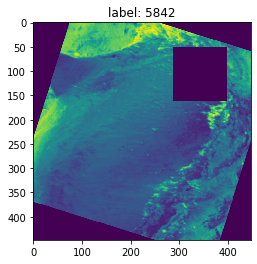

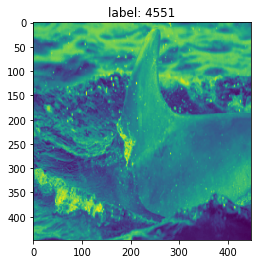

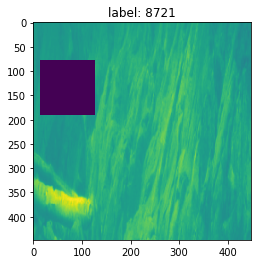

In [20]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label,label2 = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

In [21]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False,classes_n = len(classes),classes_species_n = len(classes_species)):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.num_features
#         self.model.fc = nn.Identity()
        self.classes_n = nn.Linear(n_features, classes_n)
        self.classes_species_n = nn.Linear(n_features, classes_species_n)
    def forward(self, x):
        x = self.model.forward_features(x)
        y = self.classes_n(x)
        z = self.classes_species_n(x)
        return y,z

In [22]:
#model = CustomResNext(model_name=CFG.model_name, pretrained=True)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

#for image, label in train_loader:
#    output = model(image)
#    print(output)
#    break

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, criterion_ArcFaceLoss , optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels, labels2) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device).long()
        labels2 = labels2.to(device).long()
        batch_size = labels.size(0)
        y_preds = model(images,labels)
        loss = 0.3*criterion(y_preds[0], labels) + 0.2*criterion(y_preds[1], labels2) + 0.5*criterion(y_preds[2], labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg

def emb_fn(valid_loader, model, device):
    model.eval()
    emb = []
    targets = []
    start = end = time.time()
    for step, (images, labels,labels2) in enumerate(tqdm(valid_loader)):
        # measure data loading time
        images = images.to(device)
        labels = labels.to(device).long()
        labels2 = labels2.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model.extract_feature(images).cpu().numpy()
            emb.append(y_preds)
            targets.append(labels.cpu().numpy())
    emb = np.concatenate(emb)
    targets = np.concatenate(targets)
    
    return emb,targets

def valid_fn(model,train_loader,valid_loader,run_cv = True):
    emb_v,targets_v = emb_fn(valid_loader, model, device)
    emb_t,targets_t = emb_fn(train_loader, model, device)
    res = {}
    res['emb_v'] = emb_v
    res['targets_v'] = targets_v
    res['emb_t'] = emb_t
    res['targets_t'] = targets_t
    if not run_cv: 
        return res
    tr_embeddings = res['emb_t']
    val_embeddings = res['emb_v']
    targets = res['targets_v']
    targets_train = res['targets_t']
    EMB_SIZE = 512
    vals_blend = []
    labels_blend = []
    inds_blend = []
    for i in range(1):
        vals, inds = get_topk_cossim_sub(val_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=500)
        vals = vals.data.cpu().numpy()
        inds = inds.data.cpu().numpy()
        labels = np.concatenate([targets_train[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)

        vals_blend.append(vals)
        labels_blend.append(labels)
        inds_blend.append(inds)
    vals = np.concatenate(vals_blend, axis=1)
    inds = np.concatenate(inds_blend, axis=1)
    labels = np.concatenate(labels_blend, axis=1)
    M = []
    for row in range(len(vals)):
        m = map_per_image(targets[row],labels[row])
        M.append(m)
    return np.array(M).mean()

def valid_fn_acc(valid_loader, model, criterion, criterion_ArcFaceLoss, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    preds2 = []
    start = end = time.time()
    for step, (images, labels,labels2) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device).long()
        labels2 = labels2.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images,labels)
        loss = 0.3*criterion(y_preds[0], labels) + 0.2*criterion(y_preds[1], labels2) + 0.5*criterion(y_preds[2], labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds[0].softmax(1).to('cpu').numpy())
        preds2.append(y_preds[1].softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    predictions2 = np.concatenate(preds2)
    return losses.avg, predictions,predictions2


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds[0].softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [24]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    train_loader_emb = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    #model = CustomResNext(CFG.model_name, pretrained=True)
    print(model_name)
    model = get_model(backbone_name = model_name)
#     model = timm.create_model(model_name, pretrained=True,num_classes=len(classes))
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    criterion_ArcFaceLoss = ArcFaceLoss(m=3.0)

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion , criterion_ArcFaceLoss, optimizer, epoch, scheduler, device)

        # eval
        # avg_val_loss, preds,preds2 = valid_fn(valid_loader, model, criterion , criterion_ArcFaceLoss, device)
        # valid_labels = valid_folds[CFG.target_col].values
        # valid_labels2 = valid_folds[CFG.target_col2].values
        score = valid_fn(model,train_loader_emb,valid_loader,run_cv = True)
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        # score2 = get_score(valid_labels2, preds2.argmax(1))
        # elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}')# time: {elapsed:.0f}s') #avg_val_loss: {avg_val_loss:.4f}
        
        LOGGER.info(f'Epoch {epoch+1} - metric top 5: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f}')
            torch.save({'model': model.state_dict(), },
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    #valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    #valid_folds['preds'] = check_point['preds'].argmax(1)

    return best_score

In [25]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                best_score = train_loop(folds, fold)
                LOGGER.info(f"========== fold: {fold} result ==========")
        LOGGER.info(f"========== CV ==========")
        #get_result(oof_df)
        # save result
        #oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


tf_efficientnet_b5_ns
Epoch: [1][0/3402] Data 0.876 (0.876) Elapsed 0m 1s (remain 91m 30s) Loss: 8.9461(8.9461) Grad: 28.6628  
Epoch: [1][100/3402] Data 0.000 (0.009) Elapsed 0m 40s (remain 22m 10s) Loss: 8.6544(8.6641) Grad: 18.7561  
Epoch: [1][200/3402] Data 0.000 (0.004) Elapsed 1m 17s (remain 20m 37s) Loss: 8.0288(8.4317) Grad: 14.6587  
Epoch: [1][300/3402] Data 0.000 (0.003) Elapsed 1m 54s (remain 19m 42s) Loss: 7.1340(8.2311) Grad: 11.9829  
Epoch: [1][400/3402] Data 0.000 (0.002) Elapsed 2m 31s (remain 18m 55s) Loss: 7.4967(8.1008) Grad: 12.4645  
Epoch: [1][500/3402] Data 0.000 (0.002) Elapsed 3m 8s (remain 18m 13s) Loss: 7.8051(7.9829) Grad: 16.2800  
Epoch: [1][600/3402] Data 0.000 (0.002) Elapsed 3m 45s (remain 17m 32s) Loss: 8.0777(7.8896) Grad: 10.7801  
Epoch: [1][700/3402] Data 0.000 (0.001) Elapsed 4m 22s (remain 16m 52s) Loss: 6.8960(7.8021) Grad: 10.8783  
Epoch: [1][800/3402] Data 0.000 (0.001) Elapsed 4m 59s (remain 16m 13s) Loss: 7.7739(7.7298) Grad: 11.7148  
E

In [ ]:
!nvidia-smi